In [24]:
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import GPy

In [25]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

In [26]:
grid = pd.read_csv('combined.csv')

In [27]:
grid_dates_corrected = []

for date in grid.SETTLEMENT_DATE.values:
    grid_dates_corrected.append(datetime.date(year=int(date[7:]), month=months[date[3:6].capitalize()], day=int(date[:2])))

grid['DATE'] = grid_dates_corrected

In [28]:
grid_average = grid.groupby('DATE').agg(DEMAND_AVERAGE=pd.NamedAgg('ND',aggfunc=np.mean)).reset_index()

year = []; doy = []
for date in grid_average.DATE.values:
    year.append(date.year)
    doy.append(date.timetuple().tm_yday)

grid_average['YEAR'] = year; grid_average['DOY'] = doy

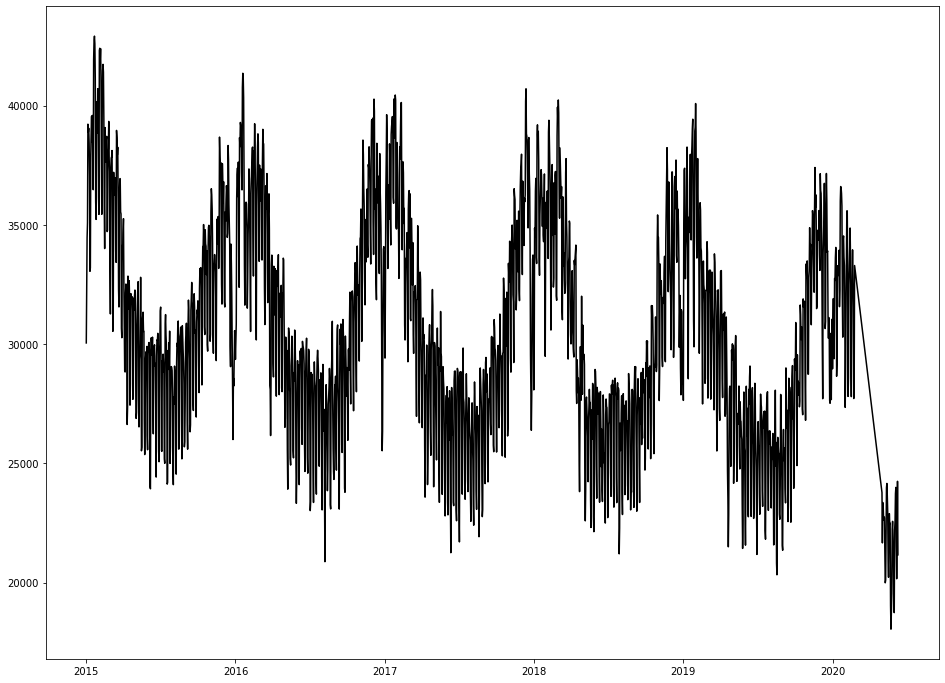

In [29]:
plt.figure(figsize=(16,12))
plt.plot(grid_average.DATE, grid_average.DEMAND_AVERAGE, c='k')
plt.show()

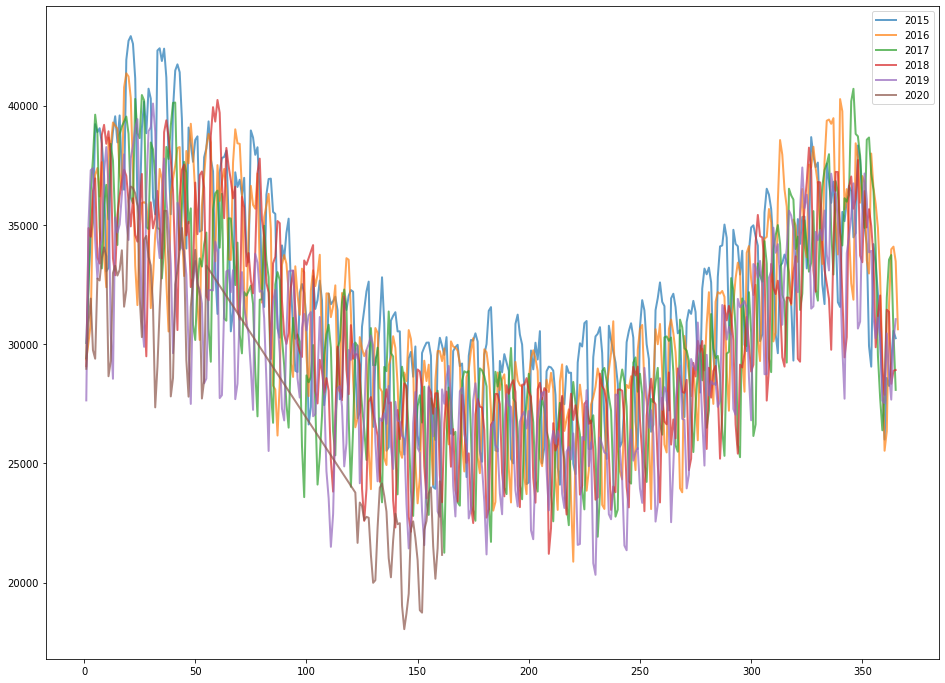

In [30]:
plt.figure(figsize=(16,12))
for year in np.unique(grid_average.YEAR.values):
    plt.plot(grid_average.DOY[grid_average.YEAR.values==year], grid_average.DEMAND_AVERAGE[grid_average.YEAR.values==year], linewidth=2, alpha=0.7, label=str(year))
plt.legend()
plt.show()

In [76]:
OFFSET = 0
X = []
for year in np.unique(grid_average.YEAR.values):
    DOY = OFFSET + grid_average.DOY[grid_average.YEAR.values==year]
    X += [i for i in DOY]
    OFFSET += max(grid_average.DOY[grid_average.YEAR.values==year])

X = np.expand_dims(np.array(X)/365, axis=1)
Y = np.expand_dims(grid_average.DEMAND_AVERAGE.values/1000, axis=1)

In [68]:
COVID_CUTOFF = 1881
#kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.Linear(input_dim=1) \
#        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1)

kernel = GPy.kern.Bias(input_dim=1, variance=1) + GPy.kern.RBF(input_dim=1, lengthscale=50) \
        + GPy.kern.RBF(input_dim=1, lengthscale=100)*GPy.kern.PeriodicExponential(input_dim=1, lengthscale=1/52, period=1) \

m = GPy.models.GPRegression(X[:COVID_CUTOFF],Y[:COVID_CUTOFF],kernel)
print(m)


Name : GP regression
Objective : 9771.482862900924
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |                 value  |  constraints  |  priors
  sum.bias.variance                         |                   1.0  |      +ve      |        
  sum.rbf.variance                          |                   1.0  |      +ve      |        
  sum.rbf.lengthscale                       |                  50.0  |      +ve      |        
  sum.mul.rbf.variance                      |                   1.0  |      +ve      |        
  sum.mul.rbf.lengthscale                   |                 100.0  |      +ve      |        
  sum.mul.periodic_exponential.variance     |                   1.0  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  0.019230769230769232  |      +ve      |        
  sum.mul.periodic_exponential.period       |                   1.0  |      +ve      |        
  G

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f498d3b9b00>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f498d3b9a90>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f498d3c50f0>]}

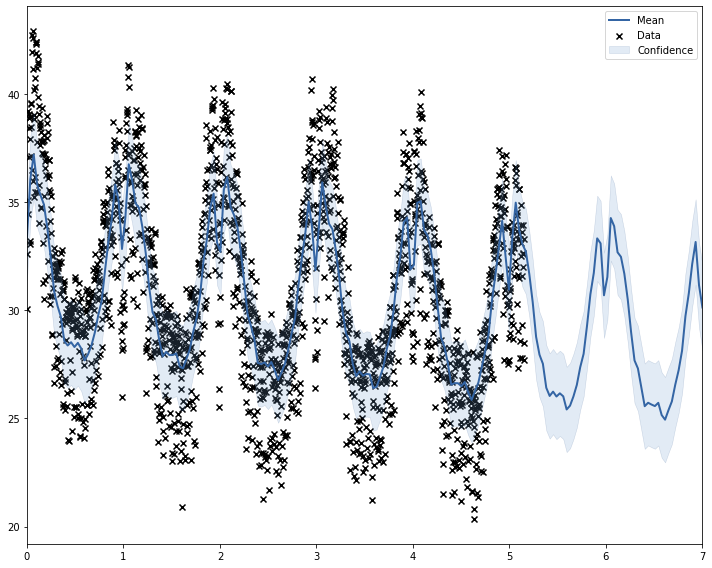

In [69]:
m.plot(figsize=(10,8), plot_limits=[0,7])

In [70]:
m.optimize()
print(m)


Name : GP regression
Objective : 4389.5584019540265
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  GP_regression.                            |               value  |  constraints  |  priors
  sum.bias.variance                         |  233.54091354996189  |      +ve      |        
  sum.rbf.variance                          |   418.7301358486422  |      +ve      |        
  sum.rbf.lengthscale                       |   28.76239770400877  |      +ve      |        
  sum.mul.rbf.variance                      |  267.09504812367436  |      +ve      |        
  sum.mul.rbf.lengthscale                   |   99.88694683349343  |      +ve      |        
  sum.mul.periodic_exponential.variance     |   267.0950481236756  |      +ve      |        
  sum.mul.periodic_exponential.lengthscale  |  126.10020071452414  |      +ve      |        
  sum.mul.periodic_exponential.period       |  1.0018474798367207  |      +ve      |        
  Gaussian_noise.var

{'dataplot': [<matplotlib.collections.PathCollection at 0x7f498d38a7f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f498d38a7b8>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f498d38ad68>]}

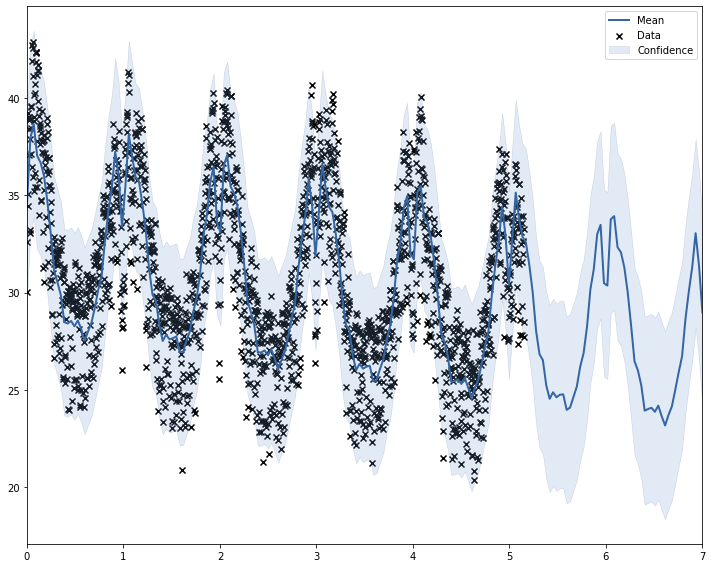

In [71]:
m.plot(figsize=(10,8), plot_limits=[0,7])

In [138]:
X_PREDICT = np.expand_dims(np.linspace(0,7,1000), axis=1)
Y_PREDICT_mean, Y_PREDICT_stdev = m.predict(X_PREDICT)

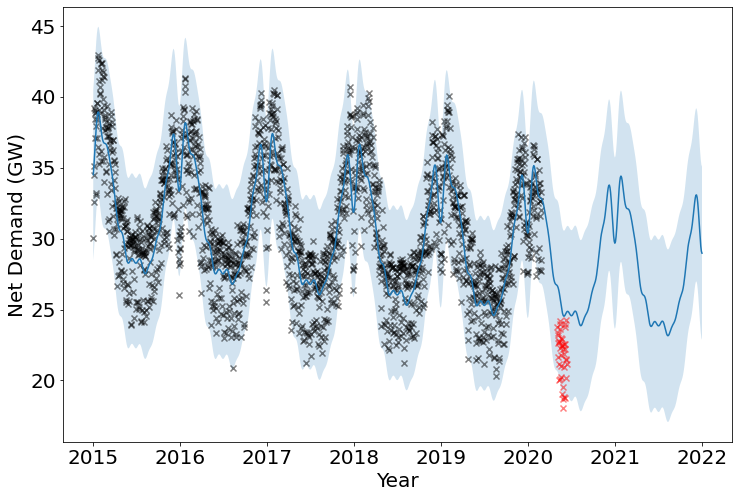

In [159]:
plt.figure(figsize=(12,8))
plt.fill_between(X_PREDICT.flatten(), (Y_PREDICT_mean-Y_PREDICT_stdev).flatten(), (Y_PREDICT_mean+Y_PREDICT_stdev).flatten(), alpha=0.2)
plt.scatter(X[:COVID_CUTOFF],Y[:COVID_CUTOFF], c='k', marker='x', alpha=0.5)
plt.scatter(X[COVID_CUTOFF:],Y[COVID_CUTOFF:], c='red', marker='x', alpha=0.5)
plt.xlabel('Year'); plt.ylabel('Net Demand (GW)')
plt.xticks(np.arange(8), np.arange(8)+2015)
plt.plot(X_PREDICT, Y_PREDICT_mean)

In [164]:
X_COVID = X[COVID_CUTOFF:]
Y_COVID = Y[COVID_CUTOFF:]
Y_COVID_PREDICT_mean, Y_COVID_PREDICT_stdev = m.predict(X_COVID)

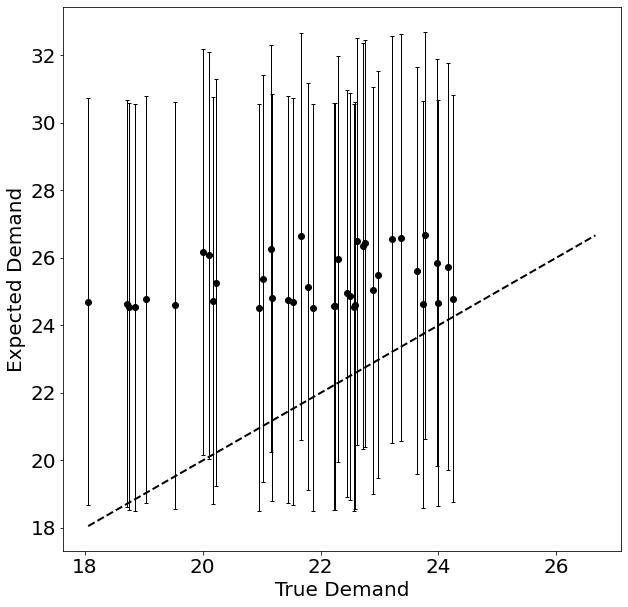

In [165]:
line = np.linspace(min(Y_COVID.min(), Y_COVID_PREDICT_mean.min()), max(Y_COVID.max(), Y_COVID_PREDICT_mean.max()))

plt.figure(figsize=(10,10))
plt.plot(line, line, 'k', linestyle='dashed', linewidth=2)
plt.errorbar(Y_COVID.flatten(), Y_COVID_PREDICT_mean.flatten(), Y_COVID_PREDICT_stdev.flatten(), fmt='o', color='k', alpha=1, linewidth=1, capsize=2)
plt.xlabel('True Demand'); plt.ylabel('Expected Demand')
plt.show()

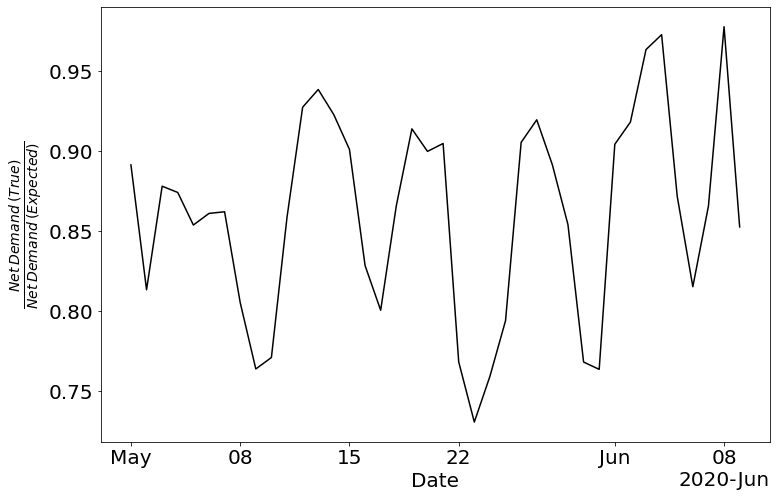

In [166]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(12,8))

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.plot(grid_average.DATE[COVID_CUTOFF:], Y_COVID.flatten()/Y_COVID_PREDICT_mean.flatten(), c='k')
ax.set_xlabel('Date'); ax.set_ylabel('$\\frac{Net \\: Demand \\: (True)}{Net \\: Demand \\: (Expected)}$')
plt.show()